# COVID-19 Situation Reports


# Analysis and Prediction using Supervised Learning Regression

In [18]:
%matplotlib inline

# Packages used in the notebook
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [19]:
# function used to call train_test_split to split the data in 75% for training and 25% for testing
def split_train_test(inputs, outputs):
    return train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# function used to train the model (search) with the training data (in_train, out_train), also gives the time elapsed
def train_model(params, search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))
    print('Best score: {}'.format(search.best_score_))
    print('Best parameters: {}'.format(search.best_params_))
    return search.best_estimator_
    
# function used to plot a bar graph to compare the data ploted using the trained model (estimator) with the actual real results (out_test)
# Also gives some statistical parameters like the Mean Absolute Error (MAE),Mean Squared Error (MSE), Root Mean Squared Error (RMSE)
# and finally the (R^2).
def check_results_test(estimator, in_test, out_test, label):
    estimator_pred = estimator.predict(in_test)
    plt.plot(out_test)
    plt.plot(estimator_pred)
    plt.legend(['Input Data', label])
    print('MAE:', mean_absolute_error(out_test, estimator_pred))
    print('MSE:',mean_squared_error(out_test, estimator_pred))
    print('RMSE:', math.sqrt(mean_squared_error(out_test, estimator_pred)))
    print('R^2:', r2_score(out_test, estimator_pred))
    
# function used to calculate and plot the cross validation score when using a trained model (estimator) and applying it
# to the inputs (inputs) and finally comparing it with the outputs (outputs).
def plot_cross_val_score(estimator, inputs, outputs, number_cv):
    cv_scores = cross_val_score(estimator, inputs, outputs, cv=number_cv)
    plt.hist(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
# function used to convert data from increments into cumulative data    
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list
    
# function used to predict  a attribute (output), for a certain country (country) using as input an array of 
# attributes (inputs_list). This prediction is done using a trained model (estimator) and using input and output data 
# from the certain country (country_inputs, country_outputs). When cumulative is True it means we are predicting
# a cumulative attribute and otherwise a incremental attribute. 
def plot_predictions_for_country(df, country, estimator, inputs_list, output, label_out, label_pred, title, cumulative=False):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs) 

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    if cumulative:
        country_pred_output = calc_cumulative(country_pred_output)
    
    print('MAE:', mean_absolute_error(country_outputs, country_pred_output))
    print('MSE:',mean_squared_error(country_outputs, country_pred_output))
    print('RMSE:', math.sqrt(mean_squared_error(country_outputs, country_pred_output)))
    print('R^2:', r2_score(country_outputs, country_pred_output))

    plt.plot(days_list, country_outputs, color='blue', label=label_out)
    plt.plot(days_list, country_pred_output, color='green', label=label_pred)
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(title + "(as of {})".format(last_day))
    plt.legend()

    
# function used to plot a learning curve using a trained model (estimator) and inputs (inputs) and outputs(outputs)
# to test the model itself
def plot_learning_curve(estimator, inputs, outputs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True,
                                       random_state=None, error_score=np.nan, return_times=False)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    
    
# function used to plot a bar graph representing the diference between the actual output values  for a country (country_outputs),
# obtained using the "output" variable ,and the ones predicted by a trained model (estimator) for a certain attribute (output) using 
# as input an array of values (country_inputs) obtained from the array "inputs_list" for that certain country
def plot_pred_diff(df, estimator, country, inputs_list, output):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs)

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    diff_list = np.subtract(country_outputs, country_pred_output)
    plt.bar(days_list, diff_list, color='blue', label="")
    plt.show()

## 3) Prediction and Regression
### 3.1) Random Forest
- - -

In [20]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


### Approach (Random Forest)

#### Brief description of the algorithm

Random forest is a Supervised Learning algorithm which uses ensemble learning method for classification and regression.
Random forest is a bagging technique and not a boosting technique. The trees in random forests are run in parallel. There is no interaction between these trees while building the trees.
It operates by constructing a multitude of decision trees at training time and outputting the class that is the mean prediction (regression) of the individual trees. Random forests correct for decision trees' habit of overfitting to their training set.

#### Steps taken to make the algorithm start predicting values

For this task we use the RandomForestRegressor class from Scikit Learn.

In order to make RandomForestRegressor start predicting values the first step needed was to do hyper parameter tuning using cross validation, for that reason, function RandomizedSearchCV() was used from sktlearn. The scoring value used by RandomizedSearchCV() to evaluate parameters was the negative mean squared error (scoring='neg_mean_squared_error'), this value was used since it is a default metric for the evaluation of the performance of most regression algorithms. For the cross validation part of this function, times of processing were evaluated and it was decided to use a 3-fold strategy with 10 iterations.

After that the model was trained using training data and at the end the model was ready to be tested and used to predict values.
It was decided it would be in the best of interests to predict values for the confimed cases first, using the following combinations of inputs and outputs:

1) Using normalized values as input and using cummulative as output
   * **inputs**: lat_norm, long_norm, num_days_from_begin_norm
   * **outputs**: confirmed
   
2) Using non normalized values as input and using cummulative as output
    * **inputs**: lat, long, num_days_from_begin
    * **outputs**: confirmed
     
3) Using normalized values as input and using increments as output
   * **inputs**: lat_norm, long_norm, num_days_from_begin_norm
   * **outputs**: confirmed_inc
     
4) Using normalized values and increments as input and using cumulative as output
    * **inputs**: lat_norm, long_norm, num_days_from_begin_norm
    * **outputs**: confirmed_inc
    
5) Using increments and normalized values, using increments as output
   * **inputs**: lat_norm, long_norm, num_days_from_begin_norm, confirmed_inc_day_before_norm
   * **outputs**: confirmed_inc

6) Using non normalized values as input and using increments as output
   * **inputs**: lat, long, num_days_from_begin
   * **outputs**: confirmed_inc
    
    
From this six combinations, one was chosen, the one with the best predictions, and used to predict the deaths and the recovered number of cases. In order to find out which combination was the best, a number of scalar parameters like the MAE, MSE, RMSE and R^2 were used to compare iterations aswell as some graphs. In the end it was discovered that the best combination was the third one using as input the normalized values of the lat, long, num_days_from_begin and as output the increment in confirmed cases. It is important to mention that in this notebook it was made an effort to test more combinations than in anothers as this was the first one. In the other notebooks only the 4 major combinations which provide the best results were analysed; 

In order to compare values in a consistent way all the graphs related to countries were always made for the same 6 countries: US, Spain, Portugal, Italy, Russia and Brazil.

#### 3.1.1) Regression for Confirmed Cases


#### 3.1.1.1) Using normalized values as input and using cummulative as output


In [21]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [22]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42], dtype=int64)

In [23]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [24]:
# create Random Forest Regressor instance, and check the hyper parameters
rf = RandomForestRegressor()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [25]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.1min finished


Elapsed time: 4.743403005599975mins
Best score: -19998895.891097233
Best parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': 80, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 348.6432568909388
MSE: 11916893.209472839
RMSE: 3452.085342147966
R^2: 0.994123724195305


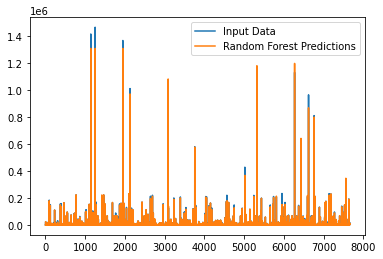

In [26]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# check the score obtained by doing cross validation with the data
plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

In [ ]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "USA Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"],
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# compute the learning curve for the estimator, using the inputs and outputs
plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.1.2) Using non normalized values as input and using cummulative as output

In [ ]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

In [ ]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

In [ ]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

In [ ]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# check the score obtained by doing cross validation with the data
plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

In [ ]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)",
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# compute the learning curve for the estimator, using the inputs and outputs
plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.1.3) Using normalized values as input and using increments as output

In [ ]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

In [ ]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Confirmed_inc"].values
outputs

In [ ]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

In [ ]:
: # try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# check the score obtained by doing cross validation with the data
plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

In [ ]:
# check the difference between the predicted increases and the real increases, for US
plot_pred_diff(
    df, rf_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed_inc"
)

In [ ]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# compute the learning curve for the estimator, using the inputs and outputs
plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.1.4)  Using normalized values and increments as input and using cumulative as output

In [ ]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

In [ ]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = new_df["Confirmed"].values
outputs

In [ ]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

In [ ]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# check the score obtained by doing cross validation with the data
plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

In [ ]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    new_df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    new_df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    new_df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    new_df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    new_df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    new_df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor"
)

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# compute the learning curve for the estimator, using the inputs and outputs
plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.1.5)  Using increments and normalized values, using increments as output

In [ ]:
# get the inputs of the data for the machine learning algorithm
inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

In [ ]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = new_df["Confirmed_inc"].values
outputs

In [ ]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

In [ ]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# check the score obtained by doing cross validation with the data
plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

In [ ]:
 # check the difference between the predicted increases and the real increases, for US
plot_pred_diff(
    new_df, rf_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed_inc"
)

In [ ]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    new_df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    new_df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    new_df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    new_df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    new_df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    new_df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# compute the learning curve for the estimator, using the inputs and outputs
plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.1.6) Using non normalized values as input and using increments as output

In [ ]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

In [ ]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Confirmed_inc"].values
outputs

In [ ]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

In [ ]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# check the score obtained by doing cross validation with the data
plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

In [ ]:
# check the difference between the predicted increases and the real increases, for US
plot_pred_diff(
    df, rf_estimator,
    "US", 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed_inc"
)

In [ ]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# compute the learning curve for the estimator, using the inputs and outputs
plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.2) Regression for Death Cases
- - -

**(Will only use Increases as output and normalized inputs, as this approach got the best results)**

In [ ]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

In [ ]:
# get the output for the machine learning algorithm (Death inc cases)
outputs = df["Deaths_inc"].values
outputs

In [ ]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

In [ ]:
# try to predict the values from the test set, calculating some statistics in order to compare result
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# check the score obtained by doing cross validation with the data
plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

In [ ]:
# check the difference between the predicted increases and the real increases, for US
plot_pred_diff(
    df, rf_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths_inc"
)

In [ ]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Death Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Death Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Death Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Death Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Death Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Deaths",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Death Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# compute the learning curve for the estimator, using the inputs and outputs
plot_learning_curve(rf_estimator_2, inputs, outputs)

#### 3.1.3) Regression for Recovered Cases
- - -

**(Will only use Increases as output and normalized inputs, as this approach got the best results)**

In [ ]:
recovered_df = df.loc[df["Recovered"].notna()]

In [ ]:
# get the inputs of the data for the machine learning algorithm
inputs = recovered_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

In [ ]:
# get the output for the machine learning algorithm (Recovered inc cases)
outputs = recovered_df["Recovered_inc"].values
outputs

In [ ]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [ ]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

#search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
rf_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
rf_estimator

In [ ]:
# try to predict the values from the test set, calculating some statistics in order to compare results
check_results_test(rf_estimator, in_conf_test, out_conf_test, 'Random Forest Predictions')

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# check the score obtained by doing cross validation with the data
plot_cross_val_score(rf_estimator_2, inputs, outputs, 10)

In [ ]:
# check the difference between the predicted increases and the real increases, for US
plot_pred_diff(
    recovered_df, rf_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered_inc"
)

In [ ]:
# generate predictions for confirmed cases in US and compare it with the real values
plot_predictions_for_country(
    recovered_df, "US", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Spain and compare it with the real values
plot_predictions_for_country(
    recovered_df, "Spain", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Brazil and compare it with the real values
plot_predictions_for_country(
    recovered_df, "Brazil", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Portugal and compare it with the real values
plot_predictions_for_country(
    recovered_df, "Portugal", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Russia and compare it with the real values
plot_predictions_for_country(
    recovered_df, "Russia", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
# generate predictions for confirmed cases in Italy and compare it with the real values
plot_predictions_for_country(
    recovered_df, "Italy", rf_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Recovered",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Recovered Cases vs Prediction from Random Forest Regressor",
    True
)

In [ ]:
rf_estimator_2 = clone(rf_estimator)

# compute the learning curve for the estimator, using the inputs and outputs
plot_learning_curve(rf_estimator_2, inputs, outputs)